# Vízminőségének osztályozása és predikciója

## Bevezető

A vízminőség monitorozása és előrejelzése kulcsfontosságú az ökoszisztéma fenntartása és a közegészségügy szempontjából. A Kaggle oldaláról származó dataset különböző vízminőségi paramétereket tartalmaz, bár meg kell jegyezzem, kihagyva pár dolgot melyet hagyományos vízmérés során szoktak pl.: foszfor-, nitrit-, nitrát tartalom. Ezen adatok alapján hozzuk, amely különböző szempontok alapján osztályozza a vízminőséget. Az így létrehozott osztályozót neurális hálóval tanítjuk, majd keresztvalidáció segítségével értékeljük a modell pontosságát és megbízhatóságát. 

### Források

Volt pár forrásra szükségem az egyes adatok osztályozásánál a besoroláshoz, melyek a dataset forrása mellett a következőek:

1. [Kaggle](https://www.kaggle.com/datasets/supriyoain/water-quality-data)
2. [Sókoncetráció besorolása](https://www.horiba.com/int/water-quality/applications/water-wastewater/measuring-salinity-of-water/)
3. [Feloldott oxigén besorolása](https://www.gov.nt.ca/sites/ecc/files/dissolved_oxygen.pdf)
4. [Ph érték halak életben maradásához](https://datastream.org/en-ca/guidebook/ph)
5. [Secchi korong ideális mélységi láthatósága](https://datastream.org/en-ca/guidebook/secchi-depth)

## Eredeti Adatkeret

Az eredeti adatkeret az alábbi oszlopokat tartalmazza, amelyek a vízminőség különböző aspektusait reprezentálják:

- **Date:** A dátumot jelöli, amikor a vízminőségi adatokat rögzítették.
- **Salinity:** A sók koncentrációját jelzi a vízben.
- **Dissolved Oxygen:** Az oldott oxigén mennyiségét mutatja a vízben, ami kulcsfontosságú a vízi élet számára.
- **pH:** A víz savassági vagy lúgossági szintjét jelenti.
- **Secchi Depth (m):** Az a mélységet, ahol egy Secchi korong eltűnik a látótérből, ami a víz átlátszóságára utal.
- **Water Depth:** A vízoszlop mélységét jelöli a mintavételi helyen.
- **Water Temperature:** A víz hőmérsékleti állapotát mutatja.
- **Air Temperature:** A mintavétel során mért környezeti levegő hőmérsékletét jelenti.

### Könyvtárak Importálása

Az elemzéshez és a modellezéshez szükséges könyvtárak importálása.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns

## Vízmérések heylszíne

Érdekesség képpen szemléltetéshez, kis kutakodás után megtaláltam a The Refuge nevezetű nemzeti parkot, ahol a mérések készültek.

In [2]:
# A vízmérések helyének koordinátái
latitude = 36.67483200779651
longitude = -75.9342008891819

# Térkép létrehozása
mymap = folium.Map(location=[latitude, longitude], zoom_start=12)

# Hely hozzáadása a térképhez
folium.Marker(location=[latitude, longitude], popup='Vízmérések helye').add_to(mymap)

# Térkép megjelenítése
mymap

## Adatok beolvasása, és adattisztítási műveletek

A következő pár kódrészlet szemlélteti a dataframe-ünk felípétését, és hogy miért kell adattísztítási műveleteket(data preparation) végrehajtani.

In [3]:
df = pd.read_csv('waterquality.csv')
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C)
0,1989-05-11,NaN,NaN,7.5,0.3,0.9,17.0,-17.777778
1,1989-05-18,NaN,12.0,7.5,0.2,0.6,17.5,20.500000
2,1989-05-25,NaN,NaN,8.0,0.4,0.8,23.0,25.000000
3,1989-06-01,NaN,12.0,8.0,0.4,0.9,25.5,29.000000
4,1989-07-11,NaN,NaN,8.5,0.3,0.9,28.5,28.000000


In [4]:
# A Date oszlop átalakítása dátum formátumra
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
num_nan_rows = df.isnull().any(axis=1).sum()
allrows = df.shape[0]
print('Sorok melyek nem tartalmaznak üres értékeket:', allrows - num_nan_rows)

Sorok melyek nem tartalmaznak üres értékeket: 1319


In [6]:
# Üres értékek eloszlásának ellenőrzése oszloponként
missing_values = df.isnull().sum()
print("Üres értékek eloszlása oszloponként:")
print(missing_values)

Üres értékek eloszlása oszloponként:
Date                        5
Salinity (ppt)            130
DissolvedOxygen (mg/L)    851
pH                         95
SecchiDepth (m)            73
WaterDepth (m)             71
WaterTemp (C)             121
AirTemp (C)                 0
dtype: int64


In [7]:
# Üres értékek kitöltése az oszlopok medián értékével
for i in df.columns[1:]:
    df[i] = df[i].fillna(df[i].median())

missing_values = df.isnull().sum()
print("Üres értékek eloszlása oszloponként:")
print(missing_values)

Üres értékek eloszlása oszloponként:
Date                      5
Salinity (ppt)            0
DissolvedOxygen (mg/L)    0
pH                        0
SecchiDepth (m)           0
WaterDepth (m)            0
WaterTemp (C)             0
AirTemp (C)               0
dtype: int64


Itt már nyugodtan dobhatjuk azt a pár oszlopot, mely nem tartalmaz date típúsú értéket, itt tényleg nem tudjuk kitölteni mediánnal, átlaggal.

In [8]:
df.dropna(inplace=True)
missing_values = df.isnull().sum()
print("Üres értékek eloszlása oszloponként:")
print(missing_values)

Üres értékek eloszlása oszloponként:
Date                      0
Salinity (ppt)            0
DissolvedOxygen (mg/L)    0
pH                        0
SecchiDepth (m)           0
WaterDepth (m)            0
WaterTemp (C)             0
AirTemp (C)               0
dtype: int64


In [9]:
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C)
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000


## Korrelációs mátrix

Érdemes létrehozni, mivel különösen jól szemlélteti az összefüggésésket adott oszlopok között.

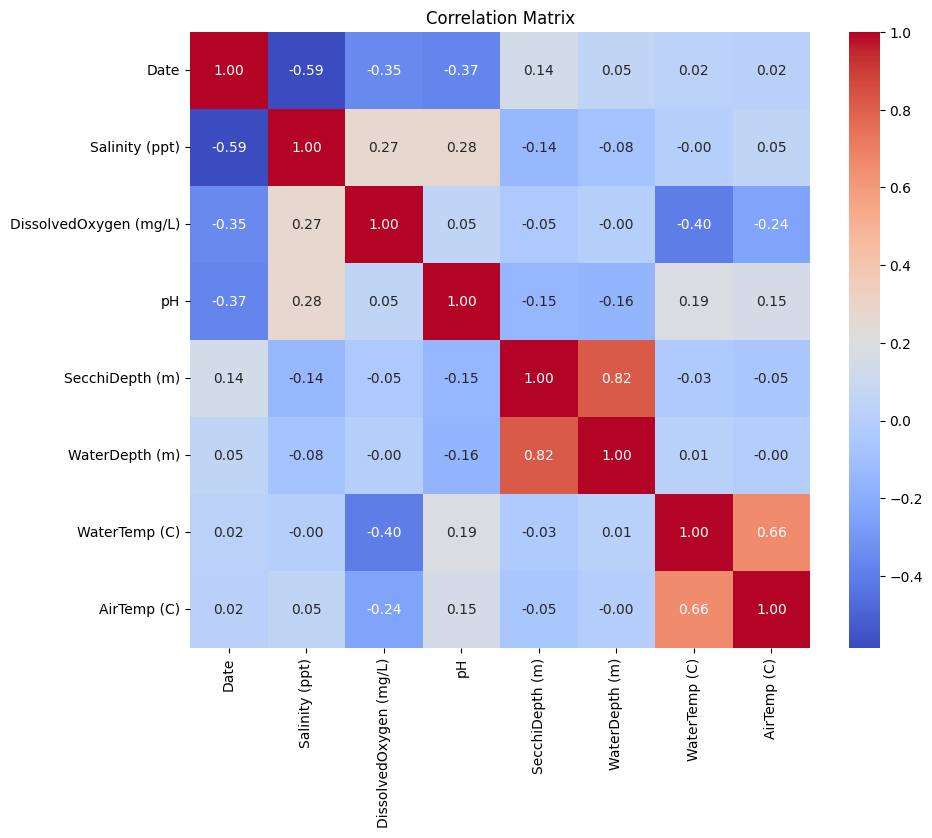

In [10]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [11]:
df.describe()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C)
count,2366,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000
mean,2006-10-09 15:36:03.651732736,0.678762,6.595063,7.162025,0.521308,0.758848,18.109810,15.688636
min,1989-05-11 00:00:00,0.000000,0.000000,0.300000,0.000000,0.010000,0.000000,-17.777778
25%,2001-10-02 00:00:00,0.000000,5.825000,6.500000,0.300000,0.400000,12.000000,8.888889
50%,2007-03-01 00:00:00,0.000000,6.500000,7.000000,0.400000,0.650000,19.000000,16.666667
75%,2012-08-09 00:00:00,1.000000,7.300000,7.500000,0.600000,0.923750,25.000000,23.888889
max,2019-11-05 00:00:00,9.000000,15.100000,9.900000,9.000000,12.000000,74.000000,33.500000
std,NaN,1.208610,2.009320,0.773894,0.467243,0.612288,8.093907,10.278043


## Osztályozás

A könyebb besorolás érdekében osztályokat definiálunk adott oszlopok értékeihez, ez később segítségünkre lesz minél pontosabb illesztésben.

In [12]:
# Osztályok definiálása
labels = ["All fish are dead", "Very few fish can live", "Most big fish can live, but some small fish can't", "All fish can live"]
bins = [0, 4, 6.5, 9, float('inf')]  # Osztályhatárok

# Osztályok hozzáadása az adathalmazhoz
df['DissolvedOxygen_Class'] = pd.cut(df['DissolvedOxygen (mg/L)'], bins=bins, labels=labels, include_lowest=True)
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C),DissolvedOxygen_Class
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778,Very few fish can live
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000,All fish can live
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000,Very few fish can live
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000,All fish can live
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000,Very few fish can live


In [13]:
# Osztályok definiálása
salinity_labels = ['Fresh', 'Marginal', 'Brackish', 'Saline', 'Highly Saline']
salinity_bins = [-float('inf'), 0.5, 1, 2, 10, float('inf')]  # Osztályhatárok

# Osztályok hozzáadása az adathalmazhoz
df['Salinity_Class'] = pd.cut(df['Salinity (ppt)'], bins=salinity_bins, labels=salinity_labels, include_lowest=True)
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C),DissolvedOxygen_Class,Salinity_Class
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778,Very few fish can live,Fresh
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000,All fish can live,Fresh
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000,Very few fish can live,Fresh
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000,All fish can live,Fresh
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000,Very few fish can live,Fresh


In [14]:
# Osztályok definiálása
ph_labels = ['Increasingly acidic', 'Neutral', 'Increasingly basic']
ph_bins = [-float('inf'), 5, 9, float('inf')]  # Osztályhatárok

# Osztályok hozzáadása az adathalmazhoz
df['pH_Class'] = pd.cut(df['pH'], bins=ph_bins, labels=ph_labels, include_lowest=True)
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C),DissolvedOxygen_Class,Salinity_Class,pH_Class
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778,Very few fish can live,Fresh,Neutral
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000,All fish can live,Fresh,Neutral
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000,Very few fish can live,Fresh,Neutral
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000,All fish can live,Fresh,Neutral
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000,Very few fish can live,Fresh,Neutral


In [15]:
# Osztályok definiálása
secchi_labels = ['Poor', 'Fair', 'Good', 'Excellent']
secchi_bins = [-float('inf'), 2, 5, 10, float('inf')]  # Osztályhatárok

# Osztályok hozzáadása az adathalmazhoz
df['SecchiDepth_Class'] = pd.cut(df['SecchiDepth (m)'], bins=secchi_bins, labels=secchi_labels, include_lowest=True)
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C),DissolvedOxygen_Class,Salinity_Class,pH_Class,SecchiDepth_Class
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778,Very few fish can live,Fresh,Neutral,Poor
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000,All fish can live,Fresh,Neutral,Poor
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000,Very few fish can live,Fresh,Neutral,Poor
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000,All fish can live,Fresh,Neutral,Poor
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000,Very few fish can live,Fresh,Neutral,Poor


A kód részeként először definiáljuk a vízminőség osztályokat, ez lesz hasznunkra tanítás során. Ezután a DataFrame kategorikus oszlopait átalakítjuk numerikus értékekké, majd hozzáadjuk az új osztályokat az adathalmazhoz, az oszlopok átlagának kiszámításával. Végül a vízminőség osztályokat is átalakítjuk numerikus értékekké.

In [16]:
# Osztályok definiálása
water_quality_labels = ['Poor', 'Acceptable', 'Good', 'Excellent']
water_quality_bins = [0, 0.25, 0.5, 0.75, 1]  # Osztályhatárok (példa értékek)

# Kategorikus oszlopok átalakítása numerikus értékekké
df[['DissolvedOxygen_Class', 'Salinity_Class', 'pH_Class', 'SecchiDepth_Class']] = df[['DissolvedOxygen_Class', 'Salinity_Class', 'pH_Class', 'SecchiDepth_Class']].apply(lambda x: x.cat.codes)

# Osztályok hozzáadása az adathalmazhoz
df['WaterQuality_Class'] = pd.cut(df[['DissolvedOxygen_Class', 'Salinity_Class',
                                       'pH_Class', 'SecchiDepth_Class']].mean(axis=1), bins=water_quality_bins, labels=water_quality_labels, include_lowest=True)

df[['WaterQuality_Class']] = df[['WaterQuality_Class']].apply(lambda x: x.cat.codes)
df.head()

,Date,Salinity (ppt),DissolvedOxygen (mg/L),pH,SecchiDepth (m),WaterDepth (m),WaterTemp (C),AirTemp (C),DissolvedOxygen_Class,Salinity_Class,pH_Class,SecchiDepth_Class,WaterQuality_Class
0,1989-05-11,0.0,6.5,7.5,0.3,0.9,17.0,-17.777778,1,0,1,0,1
1,1989-05-18,0.0,12.0,7.5,0.2,0.6,17.5,20.500000,3,0,1,0,3
2,1989-05-25,0.0,6.5,8.0,0.4,0.8,23.0,25.000000,1,0,1,0,1
3,1989-06-01,0.0,12.0,8.0,0.4,0.9,25.5,29.000000,3,0,1,0,3
4,1989-07-11,0.0,6.5,8.5,0.3,0.9,28.5,28.000000,1,0,1,0,1


## Predikció neurális hálóval

Ebben a részben fogjuk az imént osztályozott adatainkat neurális hálóra illeszteni.

Első sorban létrehozunk idő intervallumokat és azokat egy listához adjuk, mely segítségünkre lesz az adatok megjelenítésében.

In [17]:
intervals = [
    ('1988-01-01', '1994-12-31'),
    ('1995-01-01', '1999-12-31'),
    ('2001-01-01', '2005-12-31'),
    ('2006-01-01', '2010-12-31'),
    ('2011-01-01', '2015-12-31'),
    ('2016-01-01', '2019-12-31')
]

dfs = []
for start_date, end_date in intervals:
    dfs.append(df[(df['Date'] >= start_date) & (df['Date'] <= end_date)])


Ebben a kódrészletben először definiáljuk a célváltozót, majd standardizáljuk a numerikus változókat. Ezután elkészítjük a prediktor és célváltozókat, majd definiáljuk a neurális hálót. Ezután végrehajtjuk a keresztvalidációt a modell teljesítményének értékelésére. A betanított modellt a teljes adathalmazon betanítjuk, majd predikciót végzünk. Végül az eredményeket vonaldiagramon jelenítjük meg az időintervallumokra.

Keresztvalidációs pontosságok: [0.58227848 0.91754757 0.91966173 0.89006342 0.94080338]
Keresztvalidációs pontosság átlaga: 0.8500709181898467
Keresztvalidációs pontosság szórása: 0.1348633012146692


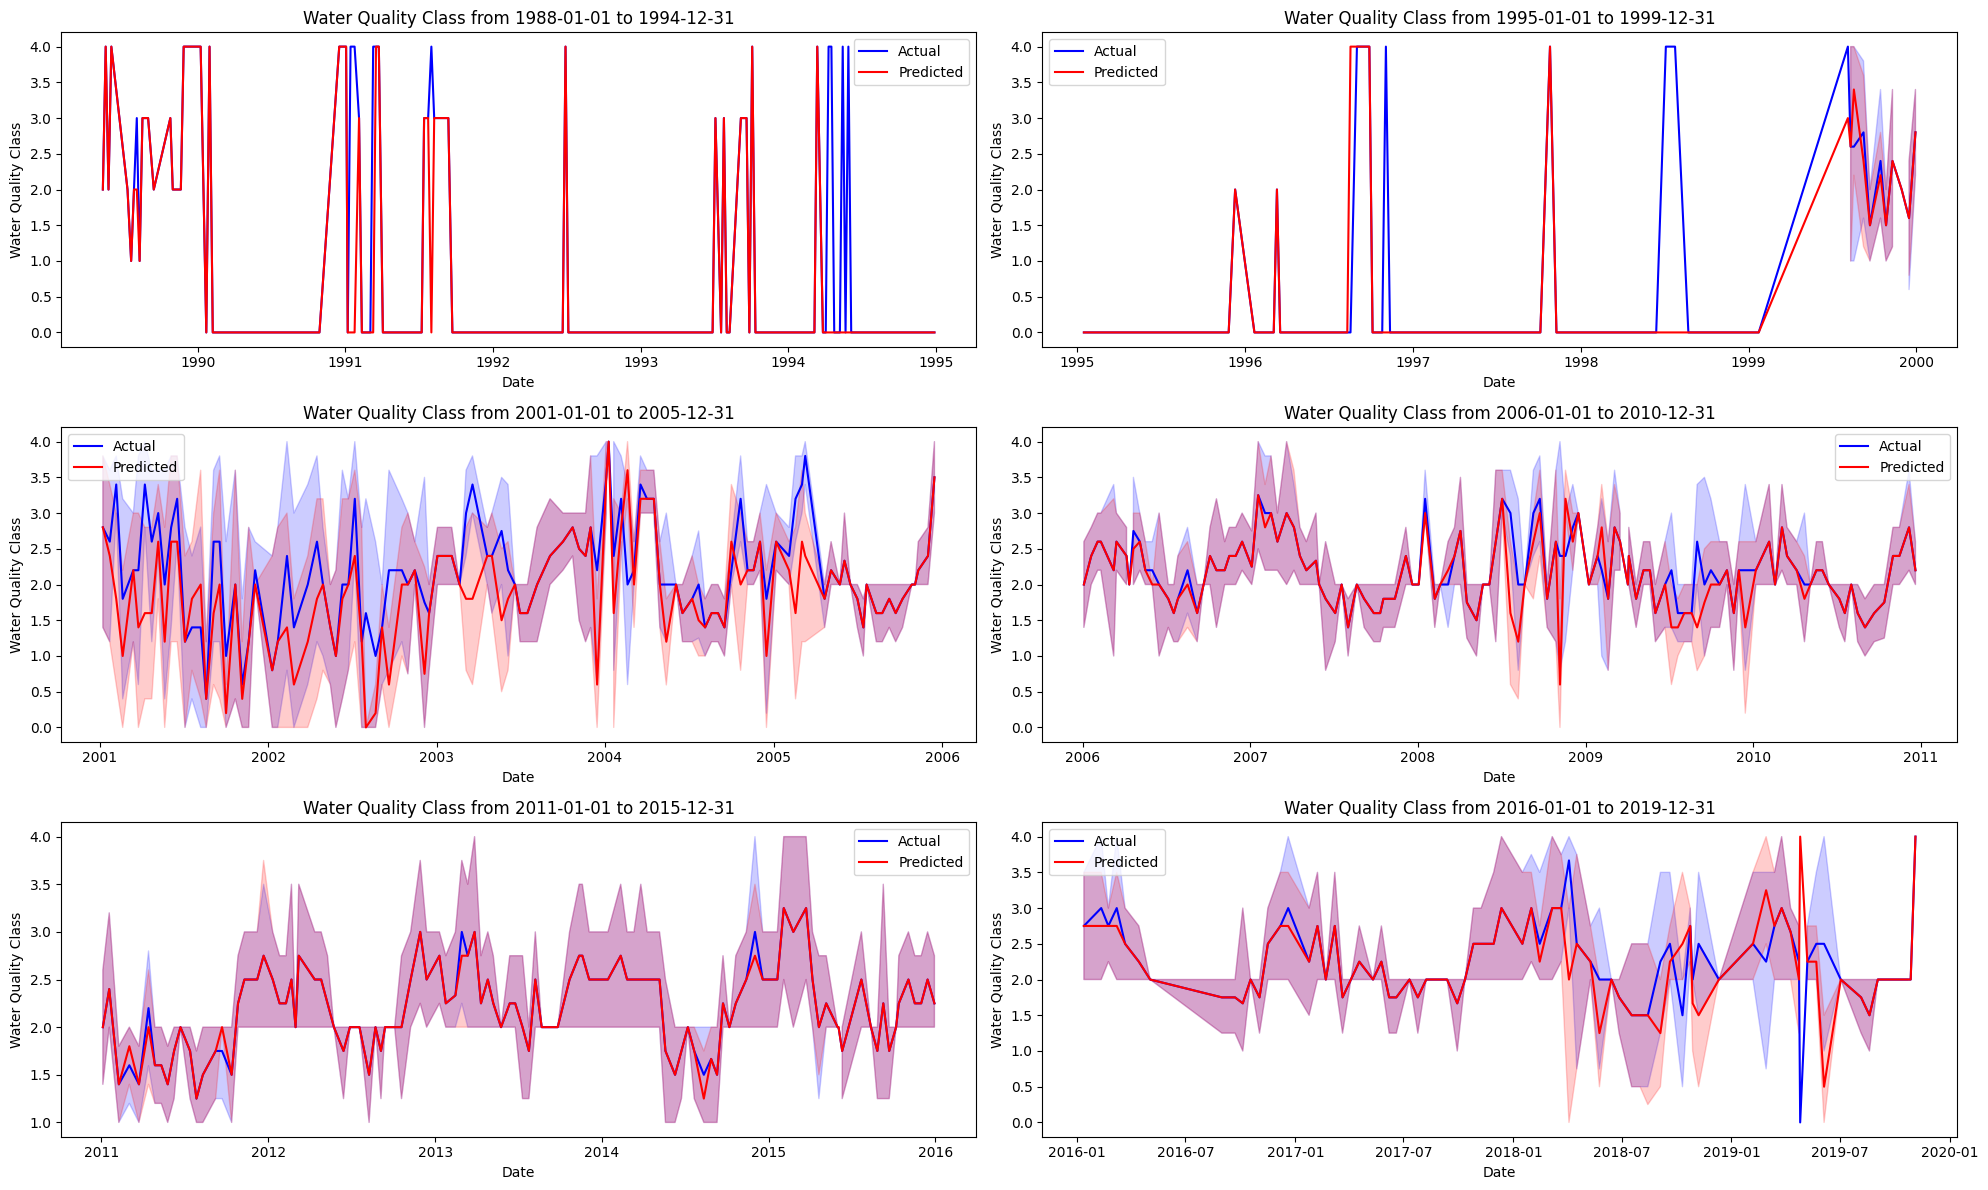

In [18]:
# Célváltozó kódolása
label_encoder = LabelEncoder()
df['WaterQuality_Class'] = label_encoder.fit_transform(df['WaterQuality_Class'])

# Standardizáljuk a numerikus változókat
scaler = StandardScaler()
numerical_features = ['Salinity (ppt)', 'DissolvedOxygen (mg/L)', 'pH', 'SecchiDepth (m)', 'WaterDepth (m)', 'WaterTemp (C)', 'AirTemp (C)']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prediktor változók és célváltozó előkészítése
X = df.drop(columns=['WaterQuality_Class', 'Date'])
y = df['WaterQuality_Class']

# Neurális háló felépítése
def create_model():
    model = MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='sgd', max_iter=200, early_stopping=True, random_state=42)
    return model

# Keresztvalidáció végrehajtása
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model = create_model()

cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# Keresztvalidációs eredmények
print(f"Keresztvalidációs pontosságok: {cv_results}")
print(f"Keresztvalidációs pontosság átlaga: {cv_results.mean()}")
print(f"Keresztvalidációs pontosság szórása: {cv_results.std()}")

# Modell betanítása teljes adathalmazon és predikció
model.fit(X, y)
predictions = model.predict(X)

# Eredmények megjelenítése vonaldiagramon
df['Predicted_WaterQuality'] = predictions

plt.figure(figsize=(20, 12))

for i, (start, end) in enumerate(intervals):
    plt.subplot(3, 2, i + 1)
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    sns.lineplot(data=df[mask], x='Date', y='WaterQuality_Class', label='Actual', color='blue')
    sns.lineplot(data=df[mask], x='Date', y='Predicted_WaterQuality', label='Predicted', color='red')
    plt.title(f'Water Quality Class from {start} to {end}')
    plt.xlabel('Date')
    plt.ylabel('Water Quality Class')
    plt.legend()

plt.tight_layout()
plt.show()

Nézzük meg egy ábrán a vízminőség érékeinek számát. Láthattó az apróbb különbség az előrejelzett és aktuális adatok között.

C:\Users\hunar\AppData\Local\Temp\ipykernel_25264\1336081381.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2", label='Actual Water Quality Class')
C:\Users\hunar\AppData\Local\Temp\ipykernel_25264\1336081381.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predictions, palette="Set2", label='Predicted Water Quality Class')


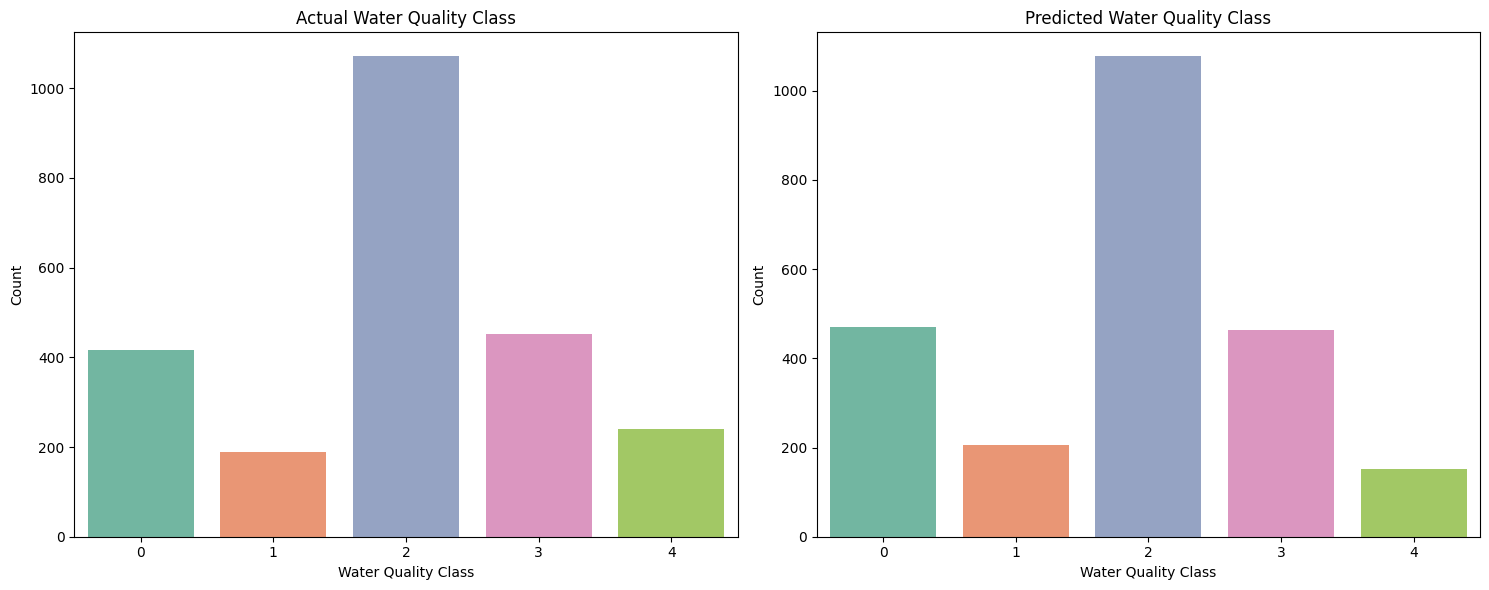

In [19]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y, palette="Set2", label='Actual Water Quality Class')
plt.xlabel('Water Quality Class')
plt.ylabel('Count')
plt.title('Actual Water Quality Class')

plt.subplot(1, 2, 2)
sns.countplot(x=predictions, palette="Set2", label='Predicted Water Quality Class')
plt.xlabel('Water Quality Class')
plt.ylabel('Count')
plt.title('Predicted Water Quality Class')

plt.tight_layout()
plt.show()

Végezrtül ábrázoljuk konfúziós mátrixon a kapott eredményeket. Itt láthatóak a helyes értékek az átlókon, és a helytelen értékek az átlón kívül. 

In [20]:
confusion_matrix = pd.crosstab(y, predictions, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2,3,4
Actual,,,,,
0,398,0,0,1,17
1,0,183,5,0,0
2,0,14,1056,0,1
3,0,7,16,425,3
4,72,1,0,37,130


In [21]:
false_predictions = confusion_matrix.values.sum() - confusion_matrix.values.diagonal().sum()

print(f'Az összes predikció: {confusion_matrix.values.sum()}')
print(f'A rossz predikciók száma: {false_predictions}')

Az összes predikció: 2366
A rossz predikciók száma: 174
